# K Nearest Neighbour algorithm
## Imports
Relevant imports for this algorithm.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import imblearn
from imblearn.combine import SMOTETomek

## Functions
Load dataset and separate X and y

In [20]:
#Load the dataset
def loadData():
    df = pd.read_csv('telecom_churn.csv')
    # Remove churn from X and put it in y
    df.drop(["MonthlyCharge", "DataUsage"], axis=1)
    X = df.drop("Churn",axis=1)
    y = df["Churn"]
    return df,X,y

### Split in data set, validation set and test set
Splits the data into three parts; Train, validation and test set. Training set for training, validation to fine tune hyperparameters and test set to train the data

In [21]:
def splitData(X, y, test_size, random_state):
    # Split dataset into train, validation and test data
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y) 
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size, random_state=random_state, stratify=y_train_val) 
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### Resample of training data set
First resample method. Resample method from SKlearn. Used to try combined method with both oversampling and undersampling. Did not give optimal results. 

In [22]:
#Resample method 1 - resample from SKlearn
def resample_dataset(X_train, y_train, random_state):
    df_train = X_train.copy()
    df_train["Churn"]=y_train

    df_majority = df_train[df_train.Churn == 0]
    df_minority = df_train[df_train.Churn == 1]

    df_min_up = resample(df_minority, replace=True, n_samples=750, random_state=random_state) #750
    df_maj_up = resample(df_majority, replace=False, n_samples=1500, random_state=random_state)

    df_up = pd.concat([df_min_up, df_maj_up])
    
    print("Counts after resample\n", df_up.Churn.value_counts())
    X_train = df_up.drop("Churn",axis=1)
    y_train = df_up["Churn"] 
    return X_train, y_train

Then we tried SMOTETomek. Resamples as explained in the method paper

In [23]:
#Resample method 2 - SMOTETomek from ImbLearn
def resample_SMOTE(X_train, y_train, random_state):
    smote = SMOTETomek(sampling_strategy=1.0, random_state=random_state)
    X_smote, y_smote = smote.fit_sample(X, y)

    return X_smote, y_smote

### Scale data set
Scales the data to more optimal values. 

In [24]:
# Scale the data into 
# Inspiration from examples from
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
def scale(X_train, X_val, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test

### Classifier
Trains the classifier

In [25]:
#Train classifier
def train_classifier(X_train, y_train, neighbors, metric):
    classifier = KNeighborsClassifier(n_neighbors=neighbors, metric=metric) #24
    classifier.fit(X_train, y_train)

    return classifier

### Best metric
Train a classifier with each distance matric and find out which metric works best.

In [26]:
def best_metric(metrics, X_train, y_train, X_val, y_val):
    metric_best = None
    best_f1_score = 0 
    for metric in metrics:
        classifier = train_classifier(X_train, y_train, 37, metric)
        y_pred = classifier.predict(X_val)
        score = round(f1_score(y_val, y_pred), 4)
        recall = round(recall_score(y_val, y_pred), 4)
        precision = round(precision_score(y_val, y_pred), 4)
        accuracy = round(accuracy_score(y_val, y_pred), 4)
        print("Metric: ", metric, " F1 score: ", score, " Recall: ", recall, 
              " Precision: ", precision, " Accuracy: ", accuracy)
        if score > best_f1_score:
            metric_best = metric
            best_f1_score = score
        
    print("Best metric: ", metric_best)
    return metric_best

## Graphs
Visualizations as classification report, confusion matrix, and error graph

### Classification report and confusion matrix

In [27]:
def show_classification_report(y, y_pred, fig_name):
    cfm = confusion_matrix(y, y_pred)

    target_names = ['Not Churn', 'Churn']
    #Classification_report
    print("\nClassification report\n")
    print(classification_report(y, y_pred, target_names=target_names))

    # The code below is taken from
    # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    # with minor changes
    group_names = ["True Negative","False Positive","False Negative","True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cfm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cfm.flatten()/np.sum(cfm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns_plot = sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    sns_plot.set_title("Confusion matrix")
    sns_plot.set_xlabel("Predicted")
    sns_plot.set_ylabel("Actual")
    sns_plot.figure.savefig('images/knn/' + fig_name + '.jpg')

### Error graph

In [28]:
def error_graph(X_train, y_train, X_val, y_val, metric):
    error = []

    # Calculating error for K values between 1 and 40
    # Code taken from
    # https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
    # with minor changes
    for i in range(1, 40):
        classifier = KNeighborsClassifier(n_neighbors=i, metric=metric)
        classifier.fit(X_train, y_train)
        pred_i = classifier.predict(X_val)
        error.append(np.mean(pred_i != y_val))
    neighbours = error.index(min(error))+1
    print("Neighbours with minimum error: ", neighbours)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')
    plt.savefig('images/knn/error_graph_knn.png')
    return neighbours

## Train dataset
Loads and splits the data

In [29]:
#Random_state and test_split
random_state = 1
test_split = 0.2

#Load data set
df, X, y = loadData()

#Split data set
X_train, X_val, X_test, y_train, y_val, y_test = splitData(X, y, test_split, random_state)

### Test before preprocessing and fine tuning hyperparameters


Classification report

              precision    recall  f1-score   support

   Not Churn       0.88      0.96      0.92       570
       Churn       0.50      0.22      0.30        97

    accuracy                           0.85       667
   macro avg       0.69      0.59      0.61       667
weighted avg       0.82      0.85      0.83       667



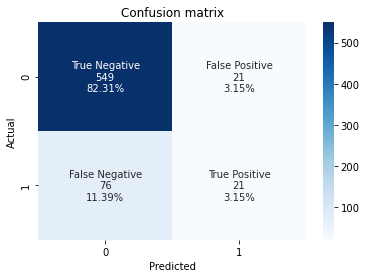

In [30]:
#Train classifier to find best K value
classifier = train_classifier(X_train, y_train, 5, "minkowski") 
#5 is default value for n_neighbours, minkowski is default metric
y_pred = classifier.predict(X_test)
show_classification_report(y_test, y_pred, "confusion_matrix_knn_original")

### Resamples and scales the data

In [31]:
#Resample data set
# X_train, y_train = resample_dataset(X_train, y_train, random_state)
X_train, y_train = resample_SMOTE(X_train, y_train, random_state)

#Scale data set
X_train, X_val, X_test = scale(X_train, X_val, X_test)

### Hyperparameter fine tuning
Finds the best metric

In [32]:
# The metrics we are going to test with to find the best metric
metrics = ["euclidean", "manhattan", "minkowski", "chebyshev"]

#Best metric
metric = best_metric(metrics, X_train, y_train, X_val, y_val) 

Metric:  euclidean  F1 score:  0.6806  Recall:  0.8442  Precision:  0.5702  Accuracy:  0.8858
Metric:  manhattan  F1 score:  0.6875  Recall:  0.8571  Precision:  0.5739  Accuracy:  0.8876
Metric:  minkowski  F1 score:  0.6806  Recall:  0.8442  Precision:  0.5702  Accuracy:  0.8858
Metric:  chebyshev  F1 score:  0.6468  Recall:  0.8442  Precision:  0.5242  Accuracy:  0.867
Best metric:  manhattan


Finds the number of neighbours with minimum error

Neighbours with minimum error:  1


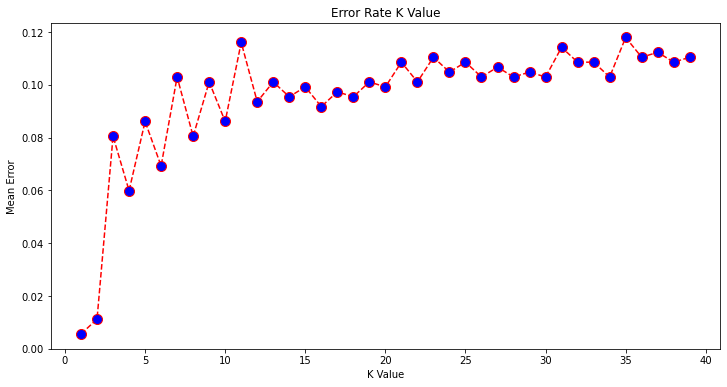

In [33]:
# find n: number of neighbours with minimum error rate
n = error_graph(X_train, y_train, X_val, y_val, metric)

In [34]:
#Train classifier 
classifier = train_classifier(X_train, y_train, n, metric)

Checks out with the validation value on how well it does


Classification report

              precision    recall  f1-score   support

   Not Churn       1.00      0.99      1.00       457
       Churn       0.96      1.00      0.98        77

    accuracy                           0.99       534
   macro avg       0.98      1.00      0.99       534
weighted avg       0.99      0.99      0.99       534



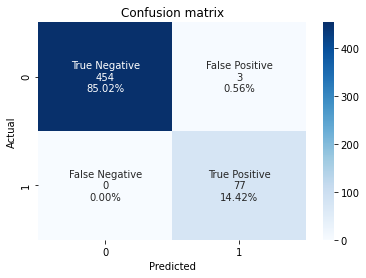

In [35]:
# Classification report
y_pred_val = classifier.predict(X_val)
show_classification_report(y_val, y_pred_val, "confusion_matrix_knn_validation")

# Test with test dataset


Classification report

              precision    recall  f1-score   support

   Not Churn       1.00      0.99      1.00       570
       Churn       0.97      1.00      0.98        97

    accuracy                           1.00       667
   macro avg       0.98      1.00      0.99       667
weighted avg       1.00      1.00      1.00       667



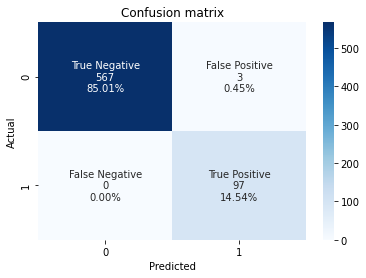

In [36]:
y_pred = classifier.predict(X_test)
show_classification_report(y_test, y_pred, "confusion_matrix_knn")